# Convolutional whitening

(Take 3)

Weights are shared across z's.

In [10]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def heatmap(data, vlims, ax, cmap="icefire"):
    """Helper function to plot heatmaps"""
    sns.heatmap(data, cmap=cmap, vmin=vlims[0], vmax=vlims[1], ax=ax)

vlims = (-5, 5)

## Simple example

### Create a structured weight matrix

In [11]:
np.random.seed(1)

N = 5
x_dim = N
y_dim = N
z_dim = 2 * N - 1

W_hat = np.zeros((y_dim, z_dim))

for i in range(z_dim):
    if i < y_dim:
        W_hat[i, i] = 1
    else:
        W_hat[i - y_dim, i] = 1
        W_hat[i - y_dim + 1, i] = 1

### Simulate

In [12]:
# random Cxx
A = np.random.randn(N, N)
Cxx = A @ A.T

u, s, vh = np.linalg.svd(Cxx)

A = u @ np.diag(np.sqrt(s)) @ vh

T = 512  # batch size
n_batch = int(2**13)
norm_w_sq = np.diag(W_hat.T @ W_hat)
eta_g = 1e-3
g = np.ones(z_dim)  # init g
all_g = []
error = []

# run simulation
for _ in tqdm(range(n_batch)):
    x = A @ np.random.randn(x_dim, T)
    M = W_hat @ np.diag(g) @ W_hat.T
    M_inv = np.linalg.inv(M)
    y = M_inv @ x

    z = W_hat.T @ y

    dg = np.mean(z**2, axis=1) - norm_w_sq
    g = g + eta_g * dg
    all_g.append(g)
    error.append(np.linalg.norm(np.cov(y) - np.eye(N)) ** 2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8192/8192 [00:02<00:00, 3011.38it/s]


### Plot

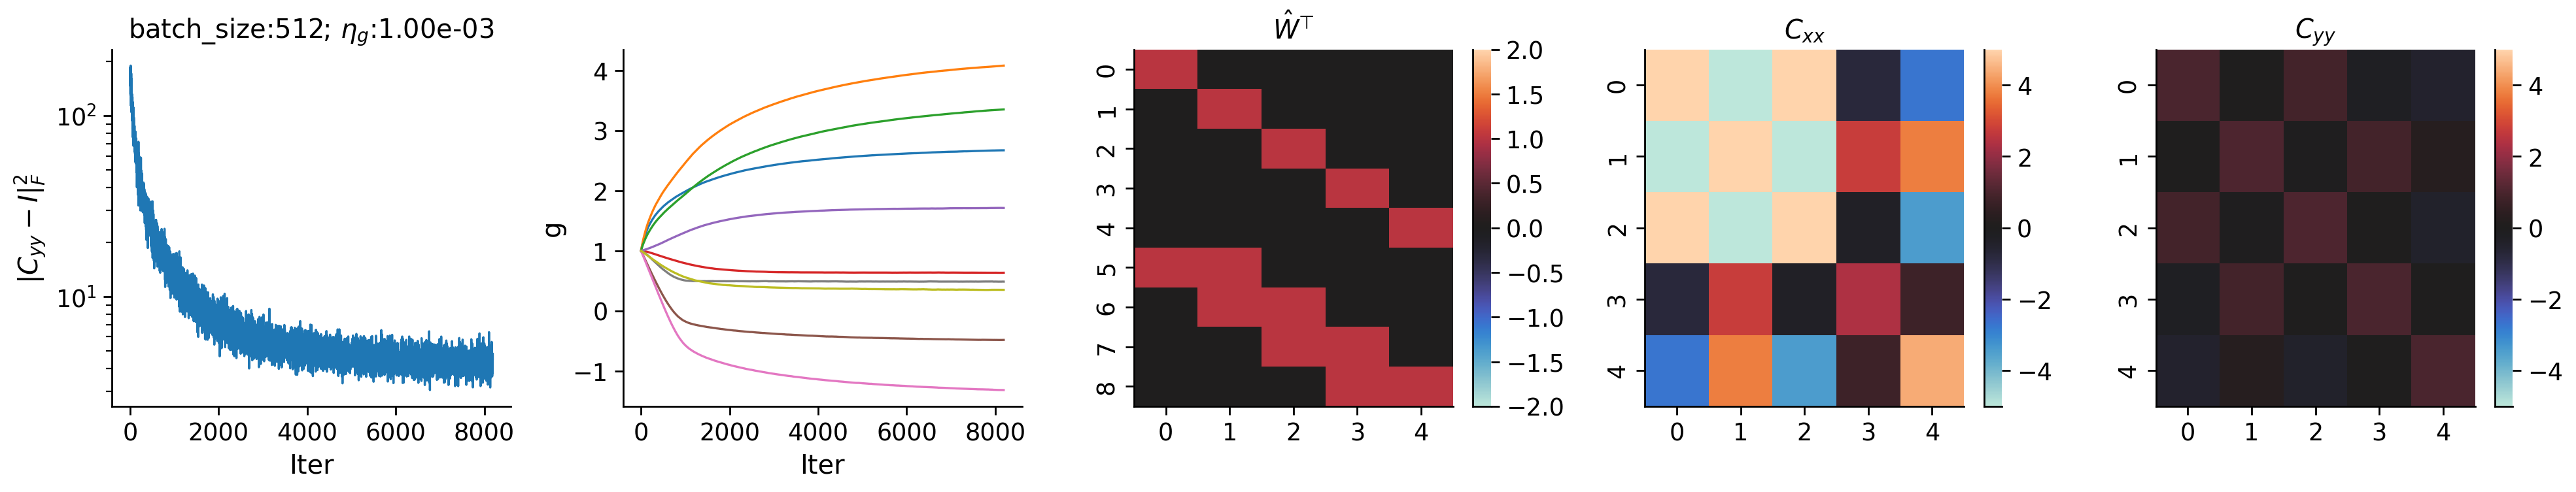

In [13]:
# compute M = (W G W.T)^-1 and Cyy
M_inv = np.linalg.inv(M)
Cyy = M_inv @ Cxx @ M_inv

with sns.plotting_context("paper", font_scale=1.5):
    fig, ax = plt.subplots(1, 5, figsize=(20, 4), dpi=200)
    ax[0].plot(error)
    ax[1].plot(all_g)
    heatmap(W_hat.T, (-2, 2), ax[2])
    heatmap(Cxx, vlims, ax[3])
    heatmap(Cyy, vlims, ax[4])

    ax[0].set(
        title=f"batch_size:{T}; $\eta_g$:{eta_g:.2e}",
        xlabel="Iter",
        ylabel=r"$\vert C_{yy}- I\vert^2_F$",
        yscale="log",
    )
    ax[1].set(title=f"", xlabel="Iter", ylabel="g")
    ax[2].set(title=r"$\hatW^\top$", xlabel="", ylabel="")
    ax[3].set(title=r"$C_{xx}$")
    ax[4].set(title=r"$C_{yy}$")
    sns.despine()
    fig.tight_layout()

## Patches of 2 adjacent neurons in 1D

[Text(0.5, 1.0, '${\\bf W}$')]

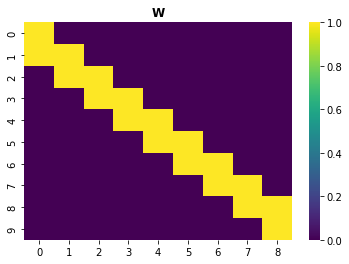

In [14]:
import scipy as sp
Ny = 10
Nz = Ny - 1

w_local = np.array((1., 1.))
w = np.concatenate((w_local, np.zeros(Ny - len(w_local))))

W = np.stack([np.roll(w, i) for i in range(Nz)],-1)


fig, ax = plt.subplots(1,1)
vlims = (0, 1)
heatmap(W, vlims, ax, cmap="viridis")
ax.set(title=r"${\bf W}$")

In [15]:
np.random.seed(42)
n_iters = 3000
batch_size = 512

A = np.random.randn(Ny, Ny)
Cxx = A @ A.T

r = np.ones(Ny)
g = np.ones(Nz)
eta_g, eta_r = 1E-2, 1E-2

w_norm_sq = np.diag(W.T @ W)
error_trace = []
error_frob = []
error_tri_diag = []

all_g = []
all_r = []
for _ in tqdm(range(n_iters)):
    x = A @ np.random.randn(Ny, batch_size)
    M = np.linalg.inv(W @ np.diag(g) @ W.T + np.diag(r))
    y = M @ x

    z = W.T @ y

    # gradients
    dg = - (np.power(z, 2).mean(-1) - w_norm_sq)
    dr = - (np.power(y, 2).mean(-1) - 1)

    g = g - eta_g * dg
    r = r - eta_g * dr


    Cyy = M @ Cxx @ M 
    err_trace = np.trace(np.abs(Cyy - np.eye(Ny)))
    err_frob = np.linalg.norm(Cyy - np.eye(Ny))**2

    # (Cyy + the k=+1, k=-1 diagonals of Cyy) minus Identity should equal 0
    err_tri_diag = np.linalg.norm(np.diag(2*Cyy,k=-1).sum() + np.trace(Cyy) - Ny)**2
    error_trace.append(err_trace)
    error_frob.append(err_frob)
    error_tri_diag.append(err_tri_diag)
    all_g.append(g)
    all_r.append(r)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1851.01it/s]


### Plot dynamics

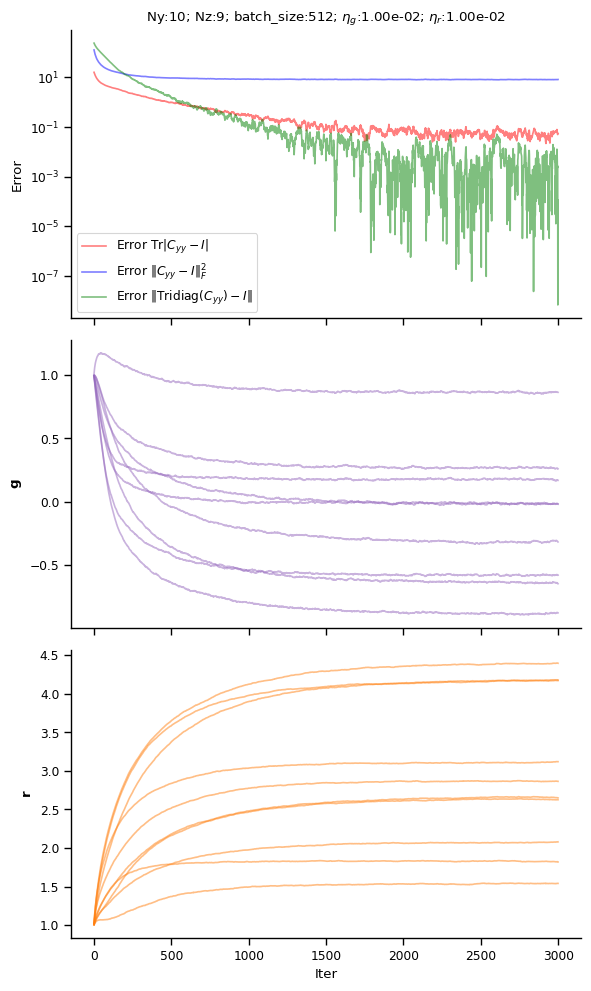

In [16]:
with sns.plotting_context("paper", font_scale=1):
    fig, ax = plt.subplots(3, 1, sharex="all", figsize=(6, 10), dpi=100)

    ax[0].plot(error_trace, color="r", alpha=.5, label=r"Error Tr$\vert C_{yy} - I\vert$")
    ax[0].plot(error_frob, color="b", alpha=.5,label=r"Error $\Vert C_{yy} - I\Vert^2_F$")
    ax[0].plot(error_tri_diag, color="g", alpha=.5,label=r"Error $\Vert \operatorname{Tridiag}(C_{yy}) - I \Vert$")
    ax[1].plot(all_g, color="C4", alpha=.5)
    ax[2].plot(all_r, color="C1", alpha=.5)
    ax[0].legend()
    ax[0].set(yscale="log", ylabel="Error",
    title=f"Ny:{Ny}; Nz:{Nz}; batch_size:{batch_size}; $\eta_g$:{eta_g:.2e}; $\eta_r$:{eta_r:.2e}")
    ax[1].set(ylabel=r"${\bf g}$")
    ax[2].set(ylabel=r"${\bf r}$", xlabel="Iter")
    fig.tight_layout()
    sns.despine()

### Plot the w Matrix and covariances

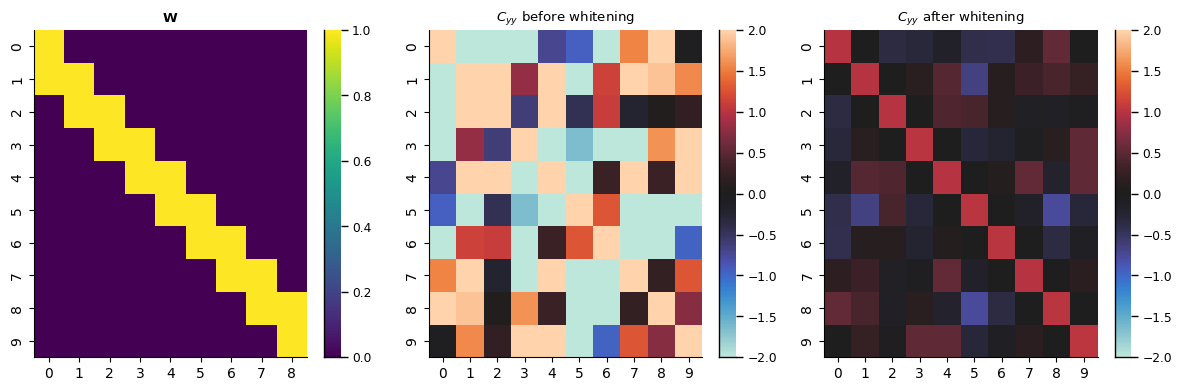

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100)
with sns.plotting_context("paper"):
    heatmap(W, (0, 1), ax[0], cmap="viridis")
    vlims = (-2, 2)
    heatmap(Cxx, vlims, ax[1], cmap="icefire")
    heatmap(M @ Cxx @ M, vlims, ax[2], cmap="icefire")

    ax[0].set(title=r"${\bf W}$")
    ax[1].set(title=r"$C_{yy}$ before whitening")
    ax[2].set(title=r"$C_{yy}$ after whitening")
    fig.tight_layout()
    sns.despine()